<a href="https://colab.research.google.com/github/WindVoiceVox/AI_Mario/blob/main/AI_Mario1_1_COMPLEX_wv_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# 強化学習を用いたマリオの訓練 
======

【原題】Train a MARIO-Playing RL Agent

【元URL】https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html

【原著】[Yuansong Feng](https://github.com/YuansongFeng), [Suraj Subramanian](https://github.com/suraj813), [Howard Wang](https://github.com/hw26), [Steven Guo](https://github.com/GuoYuzhang)

【翻訳】電通国際情報サービスISID AIトランスフォーメーションセンター　御手洗 拓真

【日付】2020年12月22日

【チュトーリアル概要】


「スーパー・マリオ・ブラザーズ」をプレイするAIマリオの実装を通じて、深層強化学習の基本について解説します。

<br>

（日本語版参考記事）

[からあげさん@karaage0703](https://twitter.com/karaage0703)の、
[Qiita記事：深層強化学習でAIマリオのクリアにチャレンジしてみた](https://qiita.com/karaage0703/items/e237887894f0f1382d58)

（このNotebookについて）

このNotebookのコードとコメントはWindVoiceが書き換えています。[御手洗さんの書かれた元の版はこちら](https://colab.research.google.com/github/YutaroOgawa/pytorch_tutorials_jp/blob/main/notebook/4_RL/4_2_mario_rl_tutorial_jp.ipynb#scrollTo=z4q0XF6G1jsW)）

---

### WindVoiceが加えた主な変更点:

本質的なところは何も変わっていません。パラメータの調整と多少のユーティリティ的なコードを書き加えました。RLに関する解説はWindVoiceが書き換えると劣化するだけなので元の翻訳版をそのままに、折りたためるように章をつけました。

1.  GPU上のメモリが16GBの場合、Mario.memoryが大きすぎてepisode=320付近でCUDAがメモリ不足となりプログラムが異常終了していました。Mario.memoryのキューサイズを57800まで下げて継続的な学習ができるようにしました。
2.   「学習結果の復元」を作って過去の学習結果を引き継げるようにしました。Mario.memoryはサイズが大きすぎて保存できない(16GB近くある)ので、完全な再現はできないことに注意してください。復元後、300エピソード程度はMario.memoryに十分な情報がないため学習に影響していると思われます。
3.  Google Driveをマウントして途中経過を保存できるようにしました。
4.  動画を撮るための「本番」は、εを小さくできるようにしたほうが良さそうなのでMario.act()にepsilon引数を指定できるようにしました。
5.  【未】Mario.act()を改造して、εをカスタマイズできるようにして実験してみたいです。右へスクロールするほどεを大きくしないと、ステージの最初の方ばかり探索することになってしまうように思われます。
6.  Colabから割り当てられたGPUを確認できるセルを冒頭に追加しました。無料版のColabではGPUを割り当てた場合16GBメモリ版が使えるようです。
7.  env.step()を確認して、rewardがどのように計算されているかを調べました。このNotebook内のclass SkipFrameからアクセスされています。gym-super-mario-brosのsmb_env.pyにSuperMarioBrosEnv._get_reward() というのがある。
8.  【未】何人目のマリオかをトータルでカウントできる仕組みがほしいです。単に記録のためです。

---
### 報酬(reward)の仕組みについて

[gym-super-mario-bros](https://github.com/Kautenja/gym-super-mario-bros/blob/master/gym_super_mario_bros/smb_env.py)の元のソースコードに含まれます。

ステップごとに-15から15までの報酬を得る可能性がある……　ような記載がありますが、実際に制限している部分が見つかりません。具体的な計算式は、①マリオのX座標、②時間の経過、③死亡によって決まっており、フラッグ（ゴール）をとってもプラスになっていません。敵を倒しても、コインをとってもプラスになっていません。そういうものかな。

X座標による報酬は-5から5の間でステップごとに計算されています。

時間の経過ペナルティはゲーム画面右上のTIMEが減るごとに-1されています。

死亡ペナルティは-25で固定値です。

なお、報酬をカスタマイズしたくなったら、このNotebook内「学習の実施」の項の中ですると良いと思います。

---

# (1) 実行環境の確認

①GPUのメモリを開放できないかとgcを試してみたが、効果はなかった。

In [ ]:
import gc
gc.collect()

74

②GPUtilはGPUの情報をとれる。どの程度GPU上のメモリが消費されているかわかる。<br />
　このAIマリオでは、Mario.memoryが多くの場所を占めている。

In [ ]:
!pip install GPUtil

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=cade95bb35588d9f753ecc2e540604cea200e127c59b77848323c2acc7e90b7a
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil


In [ ]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


③Google Colabから割り当てられているマシンの、GPUの種類を確認する。Tesla P100が多いみたい。

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jan  4 12:57:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

④仮想マシン自体に割り当てられているメモリ。13.6GBとちょっと中途半端に見える。

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


# (2) 保存先を用意（Google Drive）

Google Driveを接続して保存先を作成する。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
LOG_DIR = '/content/drive/My Drive/gym_mario/'
if os.path.exists(LOG_DIR):
    print('log dir exist.')
else:
    print('log dir not exist.')
    os.makedirs(LOG_DIR)

log dir exist.


# (3) 解説

本チュートリアルでは、深層強化学習の基本的な内容について一通り紹介します。

（以下、強化学習：Reinforcement LearningをRLと表記します。）



![](https://pytorch.org/tutorials/_images/mario.gif)


本チュートリアルを行うことで、最終的には、自力でゲームをプレイするAIマリオを実装することができます。

なお、AIマリオの実装には、[Double Deep Q-Networks](https://arxiv.org/pdf/1509.06461.pdf)を使用します。


本チュートリアルではRLについての予備知識が無くても、[RLの概念](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html)について理解できるように内容を進めます。

また、こちらの簡単な[チートシート](https://colab.research.google.com/drive/1eN33dPVtdPViiS1njTW_-r-IYCDTFU7N)（日本語版4_3）もRLの概念を理解するための参考として利用することができます。


<br>

なお、本チュートリアルの完全なコードは[こちら](https://github.com/yuansongFeng/MadMario/)に公開されています。

pipでインストールするパッケージのgym-super-mario-brosのコードは[こちら](https://github.com/Kautenja/gym-super-mario-bros)

In [ ]:
# 日本語版では、OpenAI Gymのマリオ用パッケージをインストールするセルを追加しています
!pip -q install gym-super-mario-bros==7.3.0

     |████████████████████████████████| 198 kB 8.5 MB/s 
     |████████████████████████████████| 76 kB 6.6 MB/s 


In [ ]:
# 日本語版では、Google Colab上でOpenAI Gymを動作させるために必要なパッケージをインストールしています
!apt update
!apt install xvfb
!pip -q install pyvirtualdisplay

In [ ]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, copy

# Gymは、Open AIのRL用ツールキットです
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# OpenAI Gym用に使うNES エミュレーター
from nes_py.wrappers import JoypadSpace

#OpenAI Gymのスーパー・マリオ・ブラザーズの環境
import gym_super_mario_bros

### 強化学習：RLの各種用語整理

**環境**：<br>
エージェントが相互作用をする対象であり、また、エージェントが学習を行う対象でもある世界です。
<br>

**行動** $a$ : <br>
エージェントが環境に対して行う働きかけです。<br>
エージェントが取りうる全ての行動の集合を「行動空間」と呼びます。
<br>

**状態** $s$：<br>
環境の現在の状況です。<br>
環境が成り得る全ての状態の集合を「状態空間」と呼びます。
<br>

**報酬** $r$：<br>
報酬は、環境からエージェントに対するフィードバックです。<br>
この報酬によってエージェントは学習し、行動選択を変えていきます。<br>
複数のタイムステップにわたる報酬の集合は、**利得**と呼ばれます。
<br>

**行動価値関数** $Q∗(s,a)$ : <br>
$Q$ は、状態 $s$の時にエージェントが任意の行動$a$を取り、さらに将来のタイムステップにわたって利得を最大化する行動を取った場合の、利得の期待値を返す関数です。<br>
すなわち、$Q$ はある状態 $s$での行動$a$の「質」を表していると言えます。<br>
この関数を近似した関数を作成することで、次の行動の「質」を評価して行動選択が行えるようになります。<br>

## (3-1) 環境

### 環境の初期化

ゲーム「スーパー・マリオ・ブラザーズ」の環境は、土管やキノコなどの要素で構成されています。

マリオが行動を起こすと、環境はエージェントに対し、行動の結果の情報を返します。

具体的には、環境は次の状態（＝行動によって変化した1step後の状態）や、報酬などの情報をエージェントに返すことになります。

In [ ]:
# スーパー・マリオの環境を初期化
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")

# 行動空間を以下に制限
#   0. 右に歩く
#   1. 右方向にジャンプ
# https://github.com/Kautenja/gym-super-mario-bros/blob/master/gym_super_mario_bros/actions.py
# AIマリオ第１世代の設定は以下
#env = JoypadSpace(env, [["right"], ["right", "A"]])
from gym_super_mario_bros.actions import RIGHT_ONLY
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT
# 2→12へ大幅増（何もしない、右、右＋A、右＋B、右＋AB、左、左＋A、左+AB、下、上）
env = JoypadSpace(env, COMPLEX_MOVEMENT)

env.reset()
next_state, reward, done, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

(240, 256, 3),
 0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}


### 環境の前処理

環境の状態に関する情報は、`next_state`変数を通じてエージェントに返されます。

上記のセルの出力結果から分かるように、各状態は [`3`,` 240`, `256`] というサイズの配列で表されます。

（日本語訳注：`next_state`にはゲームのプレイ画面に関する情報が格納されており、[`3`,` 240`, `256`]という配列はそれぞれ、画面の[チャネル数, 高さ、幅]を示しています。）



このような環境の情報は、ほとんどの場合、実際にエージェントが必要とするよりも情報が過多となっています。

例えば、パイプの色や空の色といった情報はマリオの行動選択には影響しないため、エージェントにとっては不要な情報です。

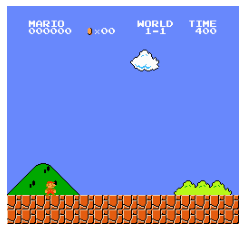

In [ ]:
# 日本語版では、上記のnext_stateを可視化した様子をサンプルとして掲載します
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(next_state)

そこで利用されるのが**ラッパー（Wrapper）**です。

ラッパーは、エージェントにデータを渡す前に、環境から返されるデータに対して前処理を行います。




以下の実装の`GrayScaleObservation`は、RGB画像をグレースケールに変換するためによく使われるラッパーです。

これにより、有用な情報を失うことなく状態を表すデータのサイズを縮小することができます。

この処理を適用すると、状態のサイズは[`1`, `240`, `256`]になります。




`ResizeObservation`は、各`observation`を正方形の画像にダウンサンプリングします。

この処理を適用すると、状態のサイズは[1, 84, 84]になります。





`SkipFrame`は`gym.Wrapper`を継承し、`step()`関数を実装したカスタムのラッパーです。

連続しているフレームはそこまで変化しないため、必要な情報をあまり失うことなく、連続したフレームの間にある、nフレームをスキップすることができます。

このとき、スキップした各フレームごとの報酬は蓄積され、n番目のフレームに集約されます。


`FrameStack`は、連続したフレームを1つにまとめ、それを学習モデルに入力できるラッパーです。

このようにすることで、マリオが着地中なのか、あるいはジャンプしているのかかを、前の数フレームの動きの方向から識別することができます。

### ステップと報酬

In [ ]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """スキップした後のフレームのみを返す"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """行動を繰り返し、報酬を合計する"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # 報酬を蓄積し、同じ行動を繰り返す
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # [H, W, C] のarrayを、[C, H, W] のtensorに変換
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# 環境にWrapperを適用
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

上記のラッパーを環境に適用すると、最終的な状態（ラップされた結果の状態）は、下図の左側の画像のように4つの連続したグレースケールのフレームを重ね合わせたものになります。

マリオが行動を取るたびに、環境はこのような構造を持つ状態を返します。

この構造は、サイズ[4, 84, 84]の3次元配列で表されます。


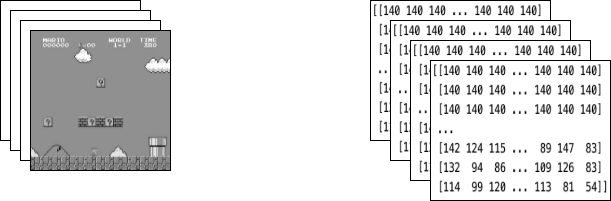

## (3-2) エージェント

ゲーム内のエージェントを表現するために、クラス「`Mario`」を作成します。

マリオは、以下の内容を実施できる必要があります。

- **行動する**:`act()`<br>
最適化された方策に従い、環境の現在の状態に応じた行動を選択し、実行します。

- **過去の経験を思い出す**: `cache()`と`recall()`<br>
経験とは、（現在の状態、現在の行動、報酬、次の状態）のことを示します。<br>
マリオは方策を更新するために、経験を一時的に記憶（*cash*）しておき、その経験を後で振り返ります（*recall*）。

- **学ぶ**:`learn()`<br>
時間をかけてより良い方策を学びます（*learn*)。


In [ ]:
class Mario:
    def __init__():
        pass

    def act(self, state):
        """状態が与えられたとき、ε-greedy法に従って行動を選択します"""
        pass

    def cache(self, experience):
        """経験をメモリに追加します"""
        pass

    def recall(self):
        """記憶からの経験のサンプリングします"""
        pass

    def learn(self):
        """経験のデータのバッチで、オンラインに行動価値関数(Q)を更新します"""
        pass

以降のセクションでは、マリオのパラメータを設定し、上記の関数を定義していきます。

### 行動（Act）


各状態において、エージェントは二つの方法で行動を選択します。

一つは「**活用**（exploit）」で、方策に基づいて最適な行動選択を行います。

もう一つは「**探索**（explore）」で、ランダムに行動を選択します。





マリオは`self.exploration_rate`の値に基づく確率で、ランダムに行動を選ぶ「探索」を選び、行動します。

一方、マリオが「活用」を選び行動する際には、`MarioNet`（本チュートリアルの「訓練」セクションで実装します）の出力をもとに、最適な行動を選び、その行動を取ることになります。

---
（追記）

actはεが大きい場合、ほぼランダムにマリオを操作します。サンプル動画を撮ろうとするときほぼランダムでは悲しいので、本番用にεを指定できるようにしました。epsilon引数を指定した場合だけ、その確率が使われるようになります。世の中にある解説を読むと、本番にあってもある程度（ε=0.1など）のランダム性をもたせるのが良いようです。

In [ ]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.use_cuda = torch.cuda.is_available()

        # 最適な行動を予測するマリオ用のDNNです。「訓練」セクションで実装します
        self.net = MarioNet(self.state_dim, self.action_dim).float()
        if self.use_cuda:
            self.net = self.net.to(device="cuda")

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 3e4  #  Netを保存するまでの実験ステップの数です

    # カスタマイズされたε値を渡せるようにした
    def act(self, state, epsilon=-1):
        """
        状態が与えられると、ε-greedy法で行動を選択し、ステップの値を更新します

        Inputs:
            state(LazyFrame):現在の状態における一つの観測オブジェクトで、(state_dim)次元となります
        Outputs:
            action_idx (int): マリオが取る行動を示す整数値です
        """
        if epsilon==-1:
            # 探索（EXPLORE）
            if np.random.rand() < self.exploration_rate:
                action_idx = np.random.randint(self.action_dim)

            # 活用（EXPLOIT）
            else:
                state = state.__array__()
                if self.use_cuda:
                    state = torch.tensor(state).cuda()
                else:
                    state = torch.tensor(state)
                state = state.unsqueeze(0)
                action_values = self.net(state, model="online")
                action_idx = torch.argmax(action_values, axis=1).item()
        else:
            # 探索（EXPLORE）
            if np.random.rand() < epsilon:
                action_idx = np.random.randint(self.action_dim)

            # 活用（EXPLOIT）
            else:
                state = state.__array__()
                if self.use_cuda:
                    state = torch.tensor(state).cuda()
                else:
                    state = torch.tensor(state)
                state = state.unsqueeze(0)
                action_values = self.net(state, model="online")
                action_idx = torch.argmax(action_values, axis=1).item()

        # exploration_rateを減衰させます
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # ステップを+1します
        self.curr_step += 1
        return action_idx

### 記憶（Cashe）と振り返り（Recall）

2つの関数（`cash`と`recall`）は、マリオの「メモリ（記憶）」の役割を果たします。

- `cache()`:<br>
マリオは行動を取るたびに、その経験をメモリに保存します。<br>
経験には、現在の状態（`state`）、次の状態（`next_state`）、実行された行動（`action`）、行動からの報酬（`reward`）ゲームが終了したかどうか（`done`）が含まれています。<br>

- `recall()`:<br>
マリオは自分のメモリからランダムに経験のバッチをサンプリングし、そのバッチを使ってゲームを学習します。




In [ ]:
class Mario(Mario):  # さきほどのクラスのサブクラスとなっています
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)

        # 100000は大きすぎて16GBのGPUではメモリ不足になるようだ。
        # maxlenでキューの長さを制限できるので、16GBに収まるサイズに小さくする。
        self.memory = deque(maxlen=57800)
        self.batch_size = 32

    def cache(self, state, next_state, action, reward, done):
        """
        経験をself.memory (replay buffer)に保存します

        Inputs:
            state (LazyFrame),
            next_state (LazyFrame),
            action (int),
            reward (float),
            done(bool))
        """
        state = state.__array__()
        next_state = next_state.__array__()

        if self.use_cuda:
            state = torch.tensor(state).cuda()
            next_state = torch.tensor(next_state).cuda()
            action = torch.tensor([action]).cuda()
            reward = torch.tensor([reward]).cuda()
            done = torch.tensor([done]).cuda()
        else:
            state = torch.tensor(state)
            next_state = torch.tensor(next_state)
            action = torch.tensor([action])
            reward = torch.tensor([reward])
            done = torch.tensor([done])

        self.memory.append((state, next_state, action, reward, done,))

    def recall(self):
        """
        メモリから経験のバッチを取得します
        """
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done = map(torch.stack, zip(*batch))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

# (4) 訓練



マリオの強化学習アルゴリズムには、[DDQNアルゴリズム](https://arxiv.org/pdf/1509.06461)を使用します。

DDQNでは、$Q_{online}$と$Q_{target}$の2つのConvNetを使用します。

それぞれのConvNetは、独立して最適な行動価値関数を近似します。



本チュートリアルの実装では、$Q_{online}$と$Q_{target}$は同じ特徴生成器を使っていますが、分類器としては別々に更新されることになります。

$θ_{target}$（$Q_{target}$のパラメータ）は、逆伝播の際に更新されないよう、固定されます。

その代わりに、$θ_{online}$の値と定期的に同期されることで、$θ_{target}$は更新されます（この点については後ほど解説します）。




#### ニューラルネットワーク

In [ ]:
class MarioNet(nn.Module):
    """
    単純なCNN構造とし、以下の通りです
    input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
    """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

        self.target = copy.deepcopy(self.online)

        # Q_target のパラメータは固定されます
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

#### TD 推論値とTDターゲット

訓練には、以下の2つの値を使用します。

**TD 推論値** : 

状態$s$において最も利得が高くなる$Q^∗$ の予測値です。以下の式で表されます。
\begin{align}{TD}_e = Q_{online}^*(s,a)\end{align}

**TD ターゲット**:

現在の状態$s$における報酬と、次の状態$s'$における$Q^∗$の推論結果を合計した値で、以下の式で表されます。

\begin{align}a' = argmax_{a} Q_{online}(s', a)\end{align}

\begin{align}{TD}_t = r + \gamma Q_{target}^*(s',a')\end{align}

実際には、現在の状態$s$からは次の状態$s'$での行動$a'$は何を採用することになるのかは不明です。

そこで、次の状態$s'$において$Q_{online}$を最大化する行動 $a'$を採用することにしています。




実装においては、`td_target()`関数には[`@torch.no_grad()`](https://pytorch.org/docs/stable/generated/torch.no_grad.html#no-grad)デコレータを使用し、勾配計算を無効にしていることに注意してください。

$\theta_{target}$は逆伝播で更新される必要がないため、このようにしています。





In [ ]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.gamma = 0.9

    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

#### モデルの更新

マリオはメモリからサンプリングしたデータを入力に、$TD_{t}$と$TD_{e}$を計算します。

そして、以下に掲載する損失の値を$Q_{online}$に逆伝播させて、パラメータ $\theta_{online}$を更新します。

\begin{align}\theta_{online} \leftarrow \theta_{online} + \alpha \nabla(TD_e - TD_t)\end{align}

ここで、$\alpha$はオプティマイザに渡される学習率`lr`を示します。




（日本語訳注：損失が$TD_{e}-TD_{t}$となっている理由について補足します。<br>
$TD_{e}$と$TD_{t}$の差が0になるということは、「現在の状態における利得の期待値」と「実際に行動して次の状態に遷移した後の利得の期待値」の差が0になる≒Q関数が正しく構築できたことを意味するため、損失は$TD_{e}-TD_{t}$と定義されています。）

一方で、逆伝播時に$\theta_{target}$は更新されません。

その代わりに、定期的に$\theta_{online}$を$\theta_{target}$にコピーすることで、$\theta_{target}$は更新されます。

$\theta_{target}$更新の数式を以下に示します。

\begin{align}\theta_{target} \leftarrow \theta_{online}\end{align}







（日本語訳注：$\theta_{target}$が逆伝播の際に更新されない理由は、$Q_{target}$が頻繁に更新されると、学習が不安定になるためです。<br>
これは、マリオが同じ場面でジャンプをした場合の評価が毎回ころころ変わってしまうと、学習が不安定になりそうとイメージすれば分かりやすいかと思います。）


In [ ]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

#### チェックポイントの保存




In [ ]:
class Mario(Mario):
    def save(self):
        save_path = (
            self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")


#### 全てをまとめたクラス




In [ ]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.burnin = 1e4  # 経験を訓練させるために最低限必要なステップ数
        self.learn_every = 3  # Q_onlineを更新するタイミングを示すステップ数
        self.sync_every = 1e4  # Q_target & Q_onlineを同期させるタイミングを示すステップ数

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # メモリからサンプリング
        state, next_state, action, reward, done = self.recall()

        # TD Estimateの取得
        td_est = self.td_estimate(state, action)

        # TD Targetの取得
        td_tgt = self.td_target(reward, next_state, done)

        # 損失をQ_onlineに逆伝播させる
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

### ログの保存




In [ ]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # 指標の履歴
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # reacord()が呼び出されるたびに追加される移動平均
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # 現在のエピソードの指標
        self.init_episode()

        # 時間を記録
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "エピソード終了時の記録"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_rewards", "ep_lengths", "ep_avg_losses", "ep_avg_qs"]:
            plt.plot(getattr(self, f"moving_avg_{metric}"))
            plt.savefig(getattr(self, f"{metric}_plot"))
            plt.clf()

# (5) 実践！
もとのNotebookを作成された方によれば、【マリオが本当にゲームの世界の攻略法を学ぶためには、最低でも4万エピソードはループすることをおすすめします。】とのことです。4万ループを回すのはなかなか大変で、Google Colabで一気通貫に実行しようとすると、おそらく24時間以上かかります。Colabの実行は不意に中断されることがあるため、学習途中の状態の保存と、再開機能が必須です。簡単ながら実装しました。

env.stepの一定回数ごとにGoogle Driveに学習状況が保存され、あとから追加の学習が行えるようにする。

save_dirには保存されるディレクトリを指定する。

In [ ]:
dt_now_JST = datetime.timezone(datetime.timedelta(hours=9))
save_dir = Path(LOG_DIR + "/checkpoints") / datetime.datetime.now(dt_now_JST).strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)
save_dir

PosixPath('/content/drive/My Drive/gym_mario/checkpoints/2022-01-04T22-02-10')

### Marioオブジェクトの初期化
Marioオブジェクトを初期化したいときにこちらを実行する。

過去の情報をロードする場合は、この初期化のあと、loadすること。

In [ ]:
mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)
logger = MetricLogger(save_dir)

### 学習の実施
---
こちらが学習のメインルーチン部分。

episodesに学習に使うマリオの人数（いわゆる残機）を指定します。

マリオの操作は、ε-greedy法によって決められるため、確率εでランダムに行動が決められます。つまり、εが1に近い間は、学習が進んでいないように見えても辛抱強くマリオを信じて待つ必要があると思われます。

---

In [ ]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

episodes = 15000 # 100あたり5分くらいかかります
#reward_queue = deque(maxlen=10)

for e in range(episodes):
    state = env.reset()
    total_reward = 0
    # ゲーム開始！
    while True:
        # 現在の状態に対するエージェントの行動を決める
        action = mario.act(state)
        # エージェントが行動を実行
        next_state, reward, done, info = env.step(action)
        # ToDo: rewardをinfoを使って調整するならここでやること
        # if info['xxx]:
        #     reward += 10
        # 記憶
        mario.cache(state, next_state, action, reward, done)
        total_reward += reward
        # 訓練
        q, loss = mario.learn()
        # ログ保存
        logger.log_step(reward, loss, q)
        # 状態の更新
        state = next_state
        # ゲームが終了したかどうかを確認
        if done or info["flag_get"]:
            if info["flag_get"]:
                # ゴールできたら知りたいですよね
                print(f"<<< Mario get the flag. GOOOOOAL! >>>")
            break
    logger.log_episode()
    if e % 20 == 0:
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)

In [ ]:
help(env)

In [ ]:
env.observation_space

Box(0, 255, (4, 84, 84), uint8)

### 学習結果の保存
Google Colabを閉じてしまうと、学習結果は失われてしまいます。定期的にGoogle Driveに保存されますが、手動で学習結果を保存したいときに以下のセルを実行します。

状態を復元するためロードするときは、先に上でmarioオブジェクトを作ってから学習状態の復元のセルを実行します。

[参考]
https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [ ]:
mario.save()

MarioNet saved to /content/drive/My Drive/gym_mario/checkpoints/2021-12-31T22-10-09/mario_net_19.chkpt at step 1959564


In [ ]:
# 保存結果をダウンロードしたい場合に実行。ファイルのパスは適宜変更して実行すること。
from google.colab import files
files.download('checkpoints/2021-12-31T11-57-37/mario_net_0.chkpt')

MarioNet saved to checkpoints/2021-12-31T11-57-37/mario_net_0.chkpt at step 160758


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 学習結果の復元

過去の状態を復元したいときは、上のMarioオブジェクトの初期化を実行したあと、下のセルを実行してオブジェクトのデータを上書きしてから、学習の実施に戻ります。

In [ ]:
LOAD_PATH = '/content/drive/My Drive/gym_mario/checkpoints/2022-01-03T21-40-09/mario_net_88.chkpt'
#torch.load(LOAD_PATH, dict(model=mario.net.state_dict(), exploration_rate=mario.exploration_rate))

In [ ]:
# checkpointからデータを読み込み
loaded_data = torch.load(LOAD_PATH)
# marioオブジェクトに値をロード
mario.net.load_state_dict(loaded_data['model'])
mario.exploration_rate = loaded_data['exploration_rate']
# mario.net.eval()

# (6) AIプレイ動画の作成





まず下のセルを実行して、ある程度良いtotal_rewardがでるまで繰り返し実行します。

3000くらいで1-1をクリアできるらしいです（未確認）。

In [ ]:
# 日本語版追加：訓練後の様子
import gym
from IPython import display
from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
from matplotlib import animation

# カラー画像表示用の環境
# マリオ環境の場合、初期状態にランダム性がないので、独立用意で良いですが、
# クリボーの初期位置などが毎回ランダムに変わる場合は、envとenv_colorの整合性をきちんと取る必要があります
# 今回は、これで問題ありません。
env_color = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env_color = JoypadSpace(env_color, COMPLEX_MOVEMENT)  # 行動空間を制限 0. 右に歩く、 1. 右方向にジャンプ

# このrewardを超えるか、ゴールできたら「成功」とする
success_reward = 4000

while True:
    # 環境と状態を初期化します
    state_color = env_color.reset()
    state = env.reset()

    # 動画作成用の画像を溜めるリスト
    d = Display()
    d.start()
    img = []
    img_color=[]
    # うまくいった？
    total_reward = 0
    # step数
    num_step = 0

    # ゲーム開始！
    while True:
        # 現在の状態に対するエージェントの行動を決める
        action = mario.act(state, epsilon=0.1)
        # エージェントが行動を実行
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        # 「本番」は学習せず、記録にも残さない。
        # 記憶
        # mario.cache(state, next_state, action, reward, done)
        # 訓練
        # q, loss = mario.learn()
        # ログ保存
        # logger.log_step(reward, loss, q)
        # 動画化に毎step描画を追加
        display.clear_output(wait=True)
        # grayscaleの画像をRGBの画像に変換
        rgb_img = np.stack((state[0],)*3,axis=0).transpose(1,2,0)
        img.append(rgb_img)
        # カラー画像用（4 skipしているので4回同じ行動をします）
        for i in range(4):
            next_state_color, _, done, _ = env_color.step(action)
            if done:
                break
        
        display.clear_output(wait=True)
        rgb_img_color = np.stack(state_color, axis=0)
        img_color.append(rgb_img_color)
        state_color = next_state_color

        # 状態の更新
        state = next_state
        num_step+=1

        # ゲームが終了したかどうかを確認
        if done or info["flag_get"]:
            if info["flag_get"]:
                print(f"<<< Mario get the flag. GOOOOOAL! >>>")
            break

    #logger.log_episode()
    #logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)
    print("num_step: %4d, reward: %5d" % ( num_step, total_reward))

    # 成功するまで繰り返し
    if total_reward > success_reward or info["flag_get"]:
        print("success!")
        break

<<< Mario get the flag. GOOOOOAL! >>>
num_step:  453, reward:  3031
success!


ある程度高いrewardがでたら、その状態を動画に変換します。もとのNotebookではgif動画にしていましたが、これはサイズが大きくなることが多く難しいので、mp4にしています。作成後は、動画ファイルがブラウザにダウンロードされます。

In [ ]:
# カラーでの動画を表示
import matplotlib.animation
matplotlib.rcParams['animation.embed_limit'] = 2**128

dpi = 72
interval = 50 # ms

plt.figure(figsize=(240/dpi, 256/dpi), dpi=dpi)  # 修正
patch = plt.imshow(img_color[0])

animate = lambda i: patch.set_data(img_color[i])
ani = animation.FuncAnimation(plt.gcf(), animate, frames=len(img_color), interval=interval)
ani.save('ai_mario.mp4')
#ani.save('ai_mario.gif')
display.display(display.HTML(ani.to_jshtml()))
plt.close()

# ダウンロード
from google.colab import files
files.download('ai_mario.mp4')
#files.download('ai_mario.gif')

In [ ]:
ani

日本語版追加：

以上

---

## おわりに
本チュートリアルでは、PyTorchを使ってゲームをプレイするAIを訓練する方法をご紹介しました。

同様の方法で、[OpenAI Gym](https://gym.openai.com)の他のゲームをプレイするAIも訓練することができます。

<br>

本チュートリアルを楽しんで頂けたでしょうか？

気になる点があれば、[私たち原著者らのgithub](https://github.com/yuansongFeng/MadMario/)に気軽にお問い合わせください！

